<img src="images/hypernet.svg" width=50% align="right">
# HyperNeworks
Author: Jin Yeom (jinyeom@utexas.edu)  
Original authors: David Ha, Andrew Dai, Quoc V. Le

## Contents
- [Configuration](#Configuration)
- [Utility functions](#Utility-functions)
- [Static HyperNet](#Static-HyperNet)
- [Dynamic HyperNet](#Dynamic-HyperNet)
- [References](#References)

In [17]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision import datasets
from torchsummary import summary
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
%matplotlib notebook

## Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


## Utility functions

In [4]:
def imshow(img, title):
    npimg = img.detach().numpy()
    plt.figure()
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## Static HyperNet

In [6]:
class HyperNet(nn.Module):
    def __init__(self, z_dim, in_channels, out_channels, kernel_size):
        super(HyperNet, self).__init__()
        self.z_dim = z_dim
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.fc1 = nn.Linear(self.z_dim, self.in_channels * self.z_dim, bias=False)      
        self.fc2 = nn.Linear(self.z_dim, self.out_channels * self.kernel_size * self.kernel_size)
        
    def forward(self, z):
        z = self.fc1(z)
        z = z.view(self.in_channels, self.z_dim)
        z = self.fc2(z)
        z = z.view(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        return z

number of trainable parameters: 4176
number of generated weights: 12544


<IPython.core.display.Javascript object>


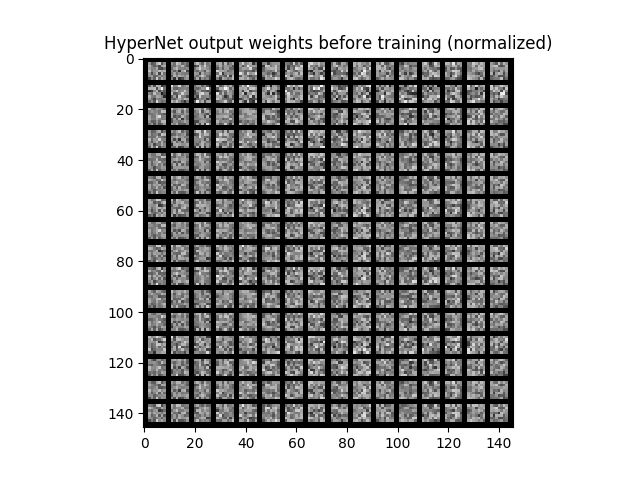

In [24]:
z_dim = 4
in_channels = 16
out_channels = 16
kernel_size = 7

z = torch.randn(z_dim, requires_grad=True)
hn = HyperNet(z_dim, in_channels, out_channels, kernel_size)
W = hn(z)

n_params = num_params(hn, requires_grad=True)
n_weights = in_channels * out_channels * kernel_size * kernel_size
print(f"number of trainable parameters: {n_params}")
print(f"number of generated weights: {n_weights}")

W_vis = W.view(in_channels * out_channels, 1, kernel_size, kernel_size)
imshow(make_grid(W_vis, nrow=in_channels, normalize=True), 
       "HyperNet output weights before training (normalized)")

In [18]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=1, out_features=10, use_hn=False):
        super(ConvNet, self).__init__()
        self._use_hn = use_hn
        self.conv1 = nn.Conv2d(in_channels, 8, 7, stride=1, padding=2)
        if self._use_hn:
            self.hn = HyperNet(4, 8, 16, 7).to(device)
            self.z = torch.randn(4, requires_grad=True).to(device)
            self.conv2_W = self.hn(self.z).to(device)
            self.conv2_b = torch.zeros(16, requires_grad=True).to(device)
        else:
            self.conv2 = nn.Conv2d(8, 16, 7, padding=2)
        self.fc3 = nn.Linear(784, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2), stride=(2, 2), padding=1)
        if self._use_hn:
            x = F.conv2d(x, self.conv2_W, self.conv2_b, padding=2)
        else:
            x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2), stride=(2, 2), padding=1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.fc3(x), dim=1)

In [21]:
model = ConvNet()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]             400
            Conv2d-2           [-1, 16, 12, 12]           6,288
            Linear-3                   [-1, 10]           7,850
Total params: 14,538
Trainable params: 14,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.06
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


In [23]:
model = ConvNet(use_hn=True)
summary(model, (1, 28, 28))
# NOTE: don't trust the numbers! They do not show all the parameters!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]             400
            Linear-2                   [-1, 10]           7,850
Total params: 8,250
Trainable params: 8,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.03
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_train = datasets.MNIST("datasets/mnist",
                                    train=True,
                                    transform=transform,
                                    download=True)
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=2)

mnist_test = datasets.MNIST("datasets/mnist",
                                   train=False,
                                   transform=transform,
                                   download=True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=64,
                                          shuffle=False,
                                          num_workers=2)

In [15]:
print("datasets/mnist/raw:")
!ls datasets/mnist/raw
print("datasets/mnist/processed:")
!ls datasets/mnist/processed

datasets/mnist/raw:
t10k-images-idx3-ubyte	train-images-idx3-ubyte
t10k-labels-idx1-ubyte	train-labels-idx1-ubyte
datasets/mnist/processed:
test.pt  training.pt


<IPython.core.display.Javascript object>


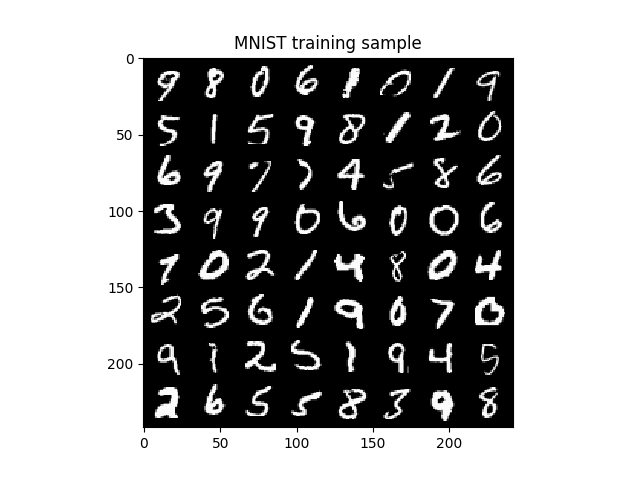

In [16]:
train_iter = iter(train_loader)
images, labels = train_iter.next()
imshow(make_grid(images, nrow=8, normalize=True), "MNIST training sample")

In [10]:
def validate(model, test_loader):
    model.eval()
    accuracy = 0.0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            pred = model(data).max(1, keepdim=True)[1] # index of max log-prob
            accuracy += pred.eq(label.view_as(pred)).sum().item()
    return 100.0 * accuracy / len(test_loader.dataset)

In [11]:
def update_figure(fig, ax, data, title, xlabel, ylabel):
    plt.tight_layout()
    ax.clear()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(data)
    plt.show()
    fig.canvas.draw()

In [12]:
def train_model(model, train_loader, test_loader, filename):
    fig, (ax_train, ax_validate) = plt.subplots(2, 1)

    train_losses = [] # training losses every 10 iterations
    validate_acc = [] # validation accuracy every 100 iterations

    best_acc = 0.0 # best accuracy during validation
    
    optimizer = optim.Adam(model.parameters())
    for epoch in tqdm(range(10), desc="epochs"):
        model.train()
        for i, (data, label) in enumerate(tqdm(train_loader, 
                                               desc="iters.", 
                                               leave=False)):
            optimizer.zero_grad()

            data = data.to(device)
            label = label.to(device)
            pred = model(data)

            loss = F.nll_loss(pred, label)
            loss.backward(retain_graph=True)
            optimizer.step()

            if i % 10 == 0:
                train_losses.append(loss.item())
                update_figure(fig,
                              ax_train,
                              train_losses,
                              "Training loss",
                              "iterations (10 iters.)",
                              "loss")

            if i % 100 == 0:
                # every 100 iterations, record the model's validation
                accuracy = validate(model, test_loader)
                if accuracy > best_acc:
                    best_acc = accuracy
                    torch.save(model, filename)
                validate_acc.append(accuracy)
                update_figure(fig,
                              ax_validate,
                              validate_acc,
                              "Validation accuracy",
                              "iterations (100 iters.)",
                              "accuracy (%)")
                print(f"Epoch {epoch} iter {i}: "
                      f"validation accuracy {accuracy}% "
                      f"best accuracy {best_acc}%")

<IPython.core.display.Javascript object>


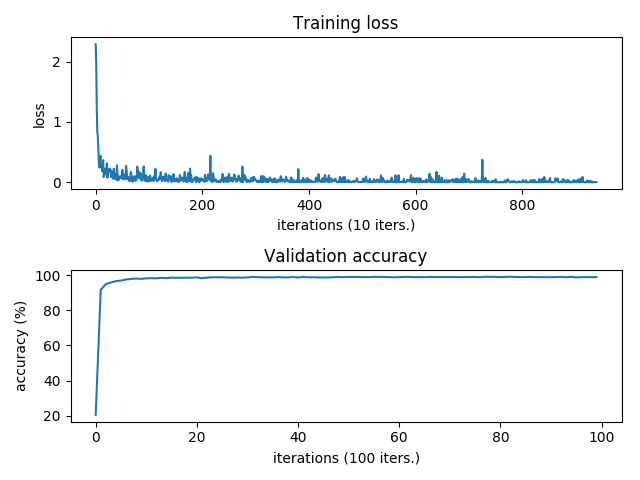

/home/jin/anaconda3/envs/research/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 0 iter 0: validation accuracy 20.47% best accuracy 20.47%
Epoch 0 iter 100: validation accuracy 91.71% best accuracy 91.71%
Epoch 0 iter 200: validation accuracy 94.89% best accuracy 94.89%
Epoch 0 iter 300: validation accuracy 95.86% best accuracy 95.86%
Epoch 0 iter 400: validation accuracy 96.6% best accuracy 96.6%
Epoch 0 iter 500: validation accuracy 96.92% best accuracy 96.92%
Epoch 0 iter 600: validation accuracy 97.53% best accuracy 97.53%
Epoch 0 iter 700: validation accuracy 97.88% best accuracy 97.88%
Epoch 0 iter 800: validation accuracy 98.08% best accuracy 98.08%
Epoch 0 iter 900: validation accuracy 97.88% best accuracy 98.08%


Epoch 1 iter 0: validation accuracy 98.21% best accuracy 98.21%
Epoch 1 iter 100: validation accuracy 98.3% best accuracy 98.3%
Epoch 1 iter 200: validation accuracy 98.23% best accuracy 98.3%
Epoch 1 iter 300: validation accuracy 98.44% best accuracy 98.44%
Epoch 1 iter 400: validation accuracy 98.27% best accuracy 98.44%
Epoch 1 iter 500: validation accuracy 98.61% best accuracy 98.61%
Epoch 1 iter 600: validation accuracy 98.49% best accuracy 98.61%
Epoch 1 iter 700: validation accuracy 98.55% best accuracy 98.61%
Epoch 1 iter 800: validation accuracy 98.58% best accuracy 98.61%
Epoch 1 iter 900: validation accuracy 98.59% best accuracy 98.61%


Epoch 2 iter 0: validation accuracy 98.74% best accuracy 98.74%
Epoch 2 iter 100: validation accuracy 98.26% best accuracy 98.74%
Epoch 2 iter 200: validation accuracy 98.64% best accuracy 98.74%
Epoch 2 iter 300: validation accuracy 98.79% best accuracy 98.79%
Epoch 2 iter 400: validation accuracy 98.83% best accuracy 98.83%
Epoch 2 iter 500: validation accuracy 98.8% best accuracy 98.83%
Epoch 2 iter 600: validation accuracy 98.71% best accuracy 98.83%
Epoch 2 iter 700: validation accuracy 98.6% best accuracy 98.83%
Epoch 2 iter 800: validation accuracy 98.72% best accuracy 98.83%
Epoch 2 iter 900: validation accuracy 98.59% best accuracy 98.83%


Epoch 3 iter 0: validation accuracy 98.73% best accuracy 98.83%
Epoch 3 iter 100: validation accuracy 99.03% best accuracy 99.03%
Epoch 3 iter 200: validation accuracy 98.87% best accuracy 99.03%
Epoch 3 iter 300: validation accuracy 98.79% best accuracy 99.03%
Epoch 3 iter 400: validation accuracy 98.79% best accuracy 99.03%
Epoch 3 iter 500: validation accuracy 98.72% best accuracy 99.03%
Epoch 3 iter 600: validation accuracy 98.93% best accuracy 99.03%
Epoch 3 iter 700: validation accuracy 98.77% best accuracy 99.03%
Epoch 3 iter 800: validation accuracy 98.74% best accuracy 99.03%
Epoch 3 iter 900: validation accuracy 98.97% best accuracy 99.03%


Epoch 4 iter 0: validation accuracy 98.68% best accuracy 99.03%
Epoch 4 iter 100: validation accuracy 98.98% best accuracy 99.03%
Epoch 4 iter 200: validation accuracy 98.8% best accuracy 99.03%
Epoch 4 iter 300: validation accuracy 98.81% best accuracy 99.03%
Epoch 4 iter 400: validation accuracy 98.73% best accuracy 99.03%
Epoch 4 iter 500: validation accuracy 98.68% best accuracy 99.03%
Epoch 4 iter 600: validation accuracy 98.72% best accuracy 99.03%
Epoch 4 iter 700: validation accuracy 98.85% best accuracy 99.03%
Epoch 4 iter 800: validation accuracy 99.0% best accuracy 99.03%
Epoch 4 iter 900: validation accuracy 98.86% best accuracy 99.03%


Epoch 5 iter 0: validation accuracy 98.99% best accuracy 99.03%
Epoch 5 iter 100: validation accuracy 99.02% best accuracy 99.03%
Epoch 5 iter 200: validation accuracy 98.96% best accuracy 99.03%
Epoch 5 iter 300: validation accuracy 98.9% best accuracy 99.03%
Epoch 5 iter 400: validation accuracy 98.9% best accuracy 99.03%
Epoch 5 iter 500: validation accuracy 99.03% best accuracy 99.03%
Epoch 5 iter 600: validation accuracy 99.05% best accuracy 99.05%
Epoch 5 iter 700: validation accuracy 99.0% best accuracy 99.05%
Epoch 5 iter 800: validation accuracy 98.89% best accuracy 99.05%
Epoch 5 iter 900: validation accuracy 98.82% best accuracy 99.05%


Epoch 6 iter 0: validation accuracy 98.91% best accuracy 99.05%
Epoch 6 iter 100: validation accuracy 99.03% best accuracy 99.05%
Epoch 6 iter 200: validation accuracy 99.03% best accuracy 99.05%
Epoch 6 iter 300: validation accuracy 98.89% best accuracy 99.05%
Epoch 6 iter 400: validation accuracy 98.92% best accuracy 99.05%
Epoch 6 iter 500: validation accuracy 98.85% best accuracy 99.05%
Epoch 6 iter 600: validation accuracy 99.01% best accuracy 99.05%
Epoch 6 iter 700: validation accuracy 98.97% best accuracy 99.05%
Epoch 6 iter 800: validation accuracy 98.92% best accuracy 99.05%
Epoch 6 iter 900: validation accuracy 98.97% best accuracy 99.05%


Epoch 7 iter 0: validation accuracy 98.9% best accuracy 99.05%
Epoch 7 iter 100: validation accuracy 98.98% best accuracy 99.05%
Epoch 7 iter 200: validation accuracy 98.88% best accuracy 99.05%
Epoch 7 iter 300: validation accuracy 98.94% best accuracy 99.05%
Epoch 7 iter 400: validation accuracy 98.92% best accuracy 99.05%
Epoch 7 iter 500: validation accuracy 99.0% best accuracy 99.05%
Epoch 7 iter 600: validation accuracy 98.84% best accuracy 99.05%
Epoch 7 iter 700: validation accuracy 99.09% best accuracy 99.09%
Epoch 7 iter 800: validation accuracy 99.04% best accuracy 99.09%
Epoch 7 iter 900: validation accuracy 99.04% best accuracy 99.09%


Epoch 8 iter 0: validation accuracy 98.89% best accuracy 99.09%
Epoch 8 iter 100: validation accuracy 99.04% best accuracy 99.09%
Epoch 8 iter 200: validation accuracy 99.12% best accuracy 99.12%
Epoch 8 iter 300: validation accuracy 99.01% best accuracy 99.12%
Epoch 8 iter 400: validation accuracy 98.9% best accuracy 99.12%
Epoch 8 iter 500: validation accuracy 98.92% best accuracy 99.12%
Epoch 8 iter 600: validation accuracy 99.02% best accuracy 99.12%
Epoch 8 iter 700: validation accuracy 98.9% best accuracy 99.12%
Epoch 8 iter 800: validation accuracy 98.91% best accuracy 99.12%
Epoch 8 iter 900: validation accuracy 98.89% best accuracy 99.12%


Epoch 9 iter 0: validation accuracy 98.86% best accuracy 99.12%
Epoch 9 iter 100: validation accuracy 98.94% best accuracy 99.12%
Epoch 9 iter 200: validation accuracy 99.01% best accuracy 99.12%
Epoch 9 iter 300: validation accuracy 98.84% best accuracy 99.12%
Epoch 9 iter 400: validation accuracy 99.06% best accuracy 99.12%
Epoch 9 iter 500: validation accuracy 98.77% best accuracy 99.12%
Epoch 9 iter 600: validation accuracy 98.87% best accuracy 99.12%
Epoch 9 iter 700: validation accuracy 98.91% best accuracy 99.12%
Epoch 9 iter 800: validation accuracy 98.86% best accuracy 99.12%
Epoch 9 iter 900: validation accuracy 98.94% best accuracy 99.12%



In [20]:
model = ConvNet().to(device)
train_model(model, train_loader, test_loader, "models/MNIST_ConvNet.pt")

<IPython.core.display.Javascript object>


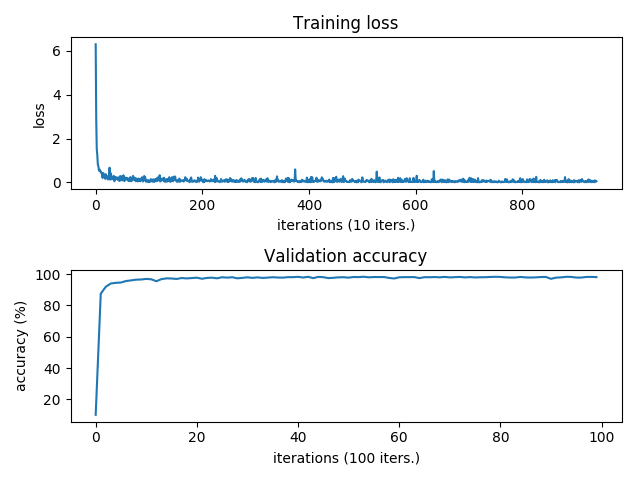

/home/jin/anaconda3/envs/research/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jin/anaconda3/envs/research/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type HyperNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 0 iter 0: validation accuracy 10.18% best accuracy 10.18%
Epoch 0 iter 100: validation accuracy 87.49% best accuracy 87.49%
Epoch 0 iter 200: validation accuracy 91.93% best accuracy 91.93%
Epoch 0 iter 300: validation accuracy 94.01% best accuracy 94.01%
Epoch 0 iter 400: validation accuracy 94.43% best accuracy 94.43%
Epoch 0 iter 500: validation accuracy 94.62% best accuracy 94.62%
Epoch 0 iter 600: validation accuracy 95.58% best accuracy 95.58%
Epoch 0 iter 700: validation accuracy 95.99% best accuracy 95.99%
Epoch 0 iter 800: validation accuracy 96.46% best accuracy 96.46%
Epoch 0 iter 900: validation accuracy 96.54% best accuracy 96.54%


Epoch 1 iter 0: validation accuracy 96.93% best accuracy 96.93%
Epoch 1 iter 100: validation accuracy 96.68% best accuracy 96.93%
Epoch 1 iter 200: validation accuracy 95.43% best accuracy 96.93%
Epoch 1 iter 300: validation accuracy 96.78% best accuracy 96.93%
Epoch 1 iter 400: validation accuracy 97.27% best accuracy 97.27%
Epoch 1 iter 500: validation accuracy 97.19% best accuracy 97.27%
Epoch 1 iter 600: validation accuracy 96.89% best accuracy 97.27%
Epoch 1 iter 700: validation accuracy 97.5% best accuracy 97.5%
Epoch 1 iter 800: validation accuracy 97.23% best accuracy 97.5%
Epoch 1 iter 900: validation accuracy 97.47% best accuracy 97.5%


Epoch 2 iter 0: validation accuracy 97.72% best accuracy 97.72%
Epoch 2 iter 100: validation accuracy 97.02% best accuracy 97.72%
Epoch 2 iter 200: validation accuracy 97.57% best accuracy 97.72%
Epoch 2 iter 300: validation accuracy 97.72% best accuracy 97.72%
Epoch 2 iter 400: validation accuracy 97.31% best accuracy 97.72%
Epoch 2 iter 500: validation accuracy 97.98% best accuracy 97.98%
Epoch 2 iter 600: validation accuracy 97.73% best accuracy 97.98%
Epoch 2 iter 700: validation accuracy 98.0% best accuracy 98.0%
Epoch 2 iter 800: validation accuracy 97.3% best accuracy 98.0%
Epoch 2 iter 900: validation accuracy 97.6% best accuracy 98.0%


Epoch 3 iter 0: validation accuracy 97.94% best accuracy 98.0%
Epoch 3 iter 100: validation accuracy 97.58% best accuracy 98.0%
Epoch 3 iter 200: validation accuracy 97.9% best accuracy 98.0%
Epoch 3 iter 300: validation accuracy 97.56% best accuracy 98.0%
Epoch 3 iter 400: validation accuracy 97.75% best accuracy 98.0%
Epoch 3 iter 500: validation accuracy 98.0% best accuracy 98.0%
Epoch 3 iter 600: validation accuracy 97.8% best accuracy 98.0%
Epoch 3 iter 700: validation accuracy 97.74% best accuracy 98.0%
Epoch 3 iter 800: validation accuracy 98.05% best accuracy 98.05%
Epoch 3 iter 900: validation accuracy 98.03% best accuracy 98.05%


Epoch 4 iter 0: validation accuracy 98.25% best accuracy 98.25%
Epoch 4 iter 100: validation accuracy 97.82% best accuracy 98.25%
Epoch 4 iter 200: validation accuracy 98.27% best accuracy 98.27%
Epoch 4 iter 300: validation accuracy 97.41% best accuracy 98.27%
Epoch 4 iter 400: validation accuracy 98.23% best accuracy 98.27%
Epoch 4 iter 500: validation accuracy 98.02% best accuracy 98.27%
Epoch 4 iter 600: validation accuracy 97.44% best accuracy 98.27%
Epoch 4 iter 700: validation accuracy 97.65% best accuracy 98.27%
Epoch 4 iter 800: validation accuracy 97.92% best accuracy 98.27%
Epoch 4 iter 900: validation accuracy 98.0% best accuracy 98.27%


Epoch 5 iter 0: validation accuracy 97.74% best accuracy 98.27%
Epoch 5 iter 100: validation accuracy 98.14% best accuracy 98.27%
Epoch 5 iter 200: validation accuracy 98.08% best accuracy 98.27%
Epoch 5 iter 300: validation accuracy 98.31% best accuracy 98.31%
Epoch 5 iter 400: validation accuracy 97.94% best accuracy 98.31%
Epoch 5 iter 500: validation accuracy 98.12% best accuracy 98.31%
Epoch 5 iter 600: validation accuracy 98.11% best accuracy 98.31%
Epoch 5 iter 700: validation accuracy 98.12% best accuracy 98.31%
Epoch 5 iter 800: validation accuracy 97.57% best accuracy 98.31%
Epoch 5 iter 900: validation accuracy 97.19% best accuracy 98.31%


Epoch 6 iter 0: validation accuracy 97.96% best accuracy 98.31%
Epoch 6 iter 100: validation accuracy 98.06% best accuracy 98.31%
Epoch 6 iter 200: validation accuracy 98.06% best accuracy 98.31%
Epoch 6 iter 300: validation accuracy 98.09% best accuracy 98.31%
Epoch 6 iter 400: validation accuracy 97.43% best accuracy 98.31%
Epoch 6 iter 500: validation accuracy 98.03% best accuracy 98.31%
Epoch 6 iter 600: validation accuracy 98.0% best accuracy 98.31%
Epoch 6 iter 700: validation accuracy 98.11% best accuracy 98.31%
Epoch 6 iter 800: validation accuracy 97.94% best accuracy 98.31%
Epoch 6 iter 900: validation accuracy 98.21% best accuracy 98.31%


Epoch 7 iter 0: validation accuracy 97.89% best accuracy 98.31%
Epoch 7 iter 100: validation accuracy 98.04% best accuracy 98.31%
Epoch 7 iter 200: validation accuracy 98.19% best accuracy 98.31%
Epoch 7 iter 300: validation accuracy 97.87% best accuracy 98.31%
Epoch 7 iter 400: validation accuracy 98.09% best accuracy 98.31%
Epoch 7 iter 500: validation accuracy 97.85% best accuracy 98.31%
Epoch 7 iter 600: validation accuracy 97.99% best accuracy 98.31%
Epoch 7 iter 700: validation accuracy 98.01% best accuracy 98.31%
Epoch 7 iter 800: validation accuracy 98.16% best accuracy 98.31%
Epoch 7 iter 900: validation accuracy 98.28% best accuracy 98.31%


Epoch 8 iter 0: validation accuracy 98.19% best accuracy 98.31%
Epoch 8 iter 100: validation accuracy 97.92% best accuracy 98.31%
Epoch 8 iter 200: validation accuracy 97.79% best accuracy 98.31%
Epoch 8 iter 300: validation accuracy 97.82% best accuracy 98.31%
Epoch 8 iter 400: validation accuracy 98.18% best accuracy 98.31%
Epoch 8 iter 500: validation accuracy 97.88% best accuracy 98.31%
Epoch 8 iter 600: validation accuracy 97.79% best accuracy 98.31%
Epoch 8 iter 700: validation accuracy 97.9% best accuracy 98.31%
Epoch 8 iter 800: validation accuracy 98.12% best accuracy 98.31%
Epoch 8 iter 900: validation accuracy 98.19% best accuracy 98.31%


Epoch 9 iter 0: validation accuracy 96.98% best accuracy 98.31%
Epoch 9 iter 100: validation accuracy 97.73% best accuracy 98.31%
Epoch 9 iter 200: validation accuracy 97.9% best accuracy 98.31%
Epoch 9 iter 300: validation accuracy 98.26% best accuracy 98.31%
Epoch 9 iter 400: validation accuracy 98.21% best accuracy 98.31%
Epoch 9 iter 500: validation accuracy 97.78% best accuracy 98.31%
Epoch 9 iter 600: validation accuracy 97.78% best accuracy 98.31%
Epoch 9 iter 700: validation accuracy 98.16% best accuracy 98.31%
Epoch 9 iter 800: validation accuracy 98.21% best accuracy 98.31%
Epoch 9 iter 900: validation accuracy 98.08% best accuracy 98.31%



In [17]:
model = ConvNet(use_hn=True).to(device)
train_model(model, train_loader, test_loader, "models/MNIST_HyperConvNet.pt")

## "Fully-Hyper"Net

This time, we're going to replace every layer in the network with a static HyperNet, including fully-connected layers.

In [10]:
class LinearHyperNet(nn.Module):
    def __init__(self, z_dim, in_features, out_features):
        super(LinearHyperNet, self).__init__()
        self.z_dim = z_dim
        self.in_features = in_features
        self.out_features = out_features
        self.fc1 = nn.Linear(self.z_dim, self.in_features * self.z_dim, bias=False)
        self.fc2 = nn.Linear(self.z_dim, self.out_features)
        
    def forward(self, z):
        z = self.fc1(z)
        z = z.view(self.in_features, self.z_dim)
        z = self.fc2(z)
        z = z.view(self.in_features, out_features)
        return z

In [11]:
z_dim = 4
in_features = 784
out_features = 10

z = torch.randn(z_dim, requires_grad=True)
hn = LinearHyperNet(z_dim, in_features, out_features)
W = hn(z)

n_params = num_params(hn, requires_grad=True)
n_weights = in_features * out_features
print(f"number of trainable parameters: {n_params}")
print(f"number of generated weights: {n_weights}")

number of trainable parameters: 12594
number of generated weights: 7840


In [12]:
class FullyHyperNet(nn.Module):
    def __init__(self, in_channels=1, out_features=10):
        super(FullyHyperNet, self).__init__()        
        self.hn1 = HyperNet(4, 1, 16, 7) # convolution layer 1
        self.hn2 = HyperNet(4, 16, 16, 7) # convolution layer 2
        self.hn3 = LinearHyperNet(4, 1, 16) # biases of convolution layers
        self.hn4 = LinearHyperNet(2, 784, 10) # fully connected layer
        self.hn5 = LinearHyperNet(2, 1, 10) # bias of fully connected layer
        
        self.z1 = torch.randn(4, requires_grad=True)
        self.z2 = torch.randn(4, requries_grad=True)
        self.z3 = torch.randn(2, requires_grad=True)
        
        self.conv1_W = self.hn1(self.z1)
        self.conv1_b = self.hn3(self.z1)
        self.conv2_W = self.hn2(self.z2)
        self.conv2_b = self.hn3(self.z2)
        self.fc3_W = self.hn4(self.z3)
        self.fc3_b = self.hn5(self.z3)
    
    def forward(self, x):
        x = F.conv2d(x, self.conv1_W, self.conv1_b, padding=2)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2), stride=(2, 2), padding=1)
        x = F.conv2d(x, self.conv2_W, self.conv2_b, padding=2)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2), stride=(2, 2), padding=1)
        x = x.view(x.size(0), -1)
        x = F.linear(x, self.fc3_W, self.fc3_b)
        return F.log_softmax(x, dim=1)

In [13]:
model1 = ConvNet()
model2 = FullyHyperNet()

print("Trainable paramters without HN: {}".format(num_params(model1, requires_grad=True)))
print("Trainable paramters with HN: {}".format(num_params(model2, requires_grad=True)))

TypeError: randn() received an invalid combination of arguments - got (int, requries_grad=bool), but expected one of:
 * (tuple of ints size, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool requires_grad)
 * (tuple of ints size, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool requires_grad)


## Dynamic HyperNet

NOTE: currently, my main interest lies in static HyperNets, as they are directly related to my current study. We'll come back to this later when I have some more free time.

## References

- HyperNetworks, [arXiv:1609.09106v4](https://arxiv.org/abs/1609.09106v4) \[cs.LG\]